In [29]:
import pandas as pd
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [30]:
Monona_df= pd.read_csv('./data/Monona.csv')
Mendota_df= pd.read_csv('./data/Mendota.csv')
Wingra_df= pd.read_csv('./data/Mendota.csv')

In [31]:
Monona_df.head(), Monona_df.shape

(    Winter Freeze-Over Date Thaw Date  Days of Ice Cover
 0  1851-52      December 13  March 25              103.0
 1  1852-53              NaN       NaN                NaN
 2  1853-54      December 21       NaN                NaN
 3  1854-55              NaN       NaN                NaN
 4  1855-56      December 18  April 14              118.0,
 (184, 4))

In [32]:
Mendota_df.head() , Mendota_df.shape

(    Winter Freeze-Over Date Thaw Date  Days of Ice Cover
 0  1852-53                –   April 5                NaN
 1  1853-54      December 27         –                NaN
 2  1854-55                –         –                NaN
 3  1855-56      December 18  April 14              118.0
 4  1856-57       December 6     May 6              151.0,
 (181, 4))

In [33]:
Wingra_df.head(), Wingra_df.shape

(    Winter Freeze-Over Date Thaw Date  Days of Ice Cover
 0  1852-53                –   April 5                NaN
 1  1853-54      December 27         –                NaN
 2  1854-55                –         –                NaN
 3  1855-56      December 18  April 14              118.0
 4  1856-57       December 6     May 6              151.0,
 (181, 4))

In [34]:
Wingra_df['date'] = Wingra_df['Freeze-Over Date'].astype(str).str.strip()
Wingra_df['month'] = Wingra_df['date'].str.extract(r'([A-Za-z]+)', expand=False)
Wingra_df['day'] = Wingra_df['date'].str.extract(r'(\d+)', expand=False)
Wingra_df['day'] = pd.to_numeric(Wingra_df['day'], errors='coerce')
Wingra_df.replace({'': None}, inplace=True)
Wingra_df

,Winter,Freeze-Over Date,Thaw Date,Days of Ice Cover,date,month,day
0,1852-53,–,April 5,NaN,–,NaN,NaN
1,1853-54,December 27,–,NaN,December 27,December,27.0
2,1854-55,–,–,NaN,–,NaN,NaN
3,1855-56,December 18,April 14,118.0,December 18,December,18.0
4,1856-57,December 6,May 6,151.0,December 6,December,6.0
...,...,...,...,...,...,...,...
176,2021-22,January 7,April 2,85.0,January 7,January,7.0
177,2022-23,December 25,April 2,98.0,December 25,December,25.0
178,2023-24,January 15,February 28,44.0,January 15,January,15.0
179,2024-25,January 7,NaN,NaN,January 7,January,7.0


In [35]:
def preprocess(df):
    df = df.copy()
    month_to_num = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    df['year'] = df['Winter'].str[:4].astype(int)
    
    df['date'] = df['Freeze-Over Date'].astype(str).str.strip()
    df['freeze_month'] = df['date'].str.extract(r'([A-Za-z]+)', expand=False)
    df['freeze_month'] = df['freeze_month'].map(month_to_num)
    df['freeze_day'] = df['date'].str.extract(r'(\d+)', expand=False)
    df['freeze_day'] = pd.to_numeric(df['freeze_day'], errors='coerce')
    
    df['thaw_date'] = df['Thaw Date'].astype(str).str.strip()
    df['thaw_month'] = df['thaw_date'].str.extract(r'([A-Za-z]+)', expand=False)
    df['thaw_month'] = df['thaw_month'].map(month_to_num)
    df['thaw_day'] = df['thaw_date'].str.extract(r'(\d+)', expand=False)
    df['thaw_day'] = pd.to_numeric(df['thaw_day'], errors='coerce')
    
    #Clean up missing values
    df.replace({'–': None, '': None}, inplace=True)
    df['Days of Ice Cover'] = df['Days of Ice Cover'].fillna(0)
    
    df.drop(['Winter', 'date', 'thaw_date', 'Freeze-Over Date', 'Thaw Date'], axis=1, inplace=True)
    
    return df

In [36]:
preprocess(Monona_df)

,Days of Ice Cover,year,freeze_month,freeze_day,thaw_month,thaw_day
0,103.0,1851,12.0,13.0,3.0,25.0
1,0.0,1852,NaN,NaN,NaN,NaN
2,0.0,1853,12.0,21.0,NaN,NaN
3,0.0,1854,NaN,NaN,NaN,NaN
4,118.0,1855,12.0,18.0,4.0,14.0
...,...,...,...,...,...,...
179,91.0,2022,12.0,19.0,3.0,20.0
180,44.0,2023,1.0,15.0,2.0,28.0
181,0.0,2024,1.0,5.0,NaN,NaN
182,0.0,2024,12.0,22.0,12.0,28.0


In [37]:
Monona_processed = preprocess(Monona_df)
Mendota_processed = preprocess(Mendota_df)
Wingra_processed = preprocess(Wingra_df)

Monona_processed['lake'] = 'Monona'
Mendota_processed['lake'] = 'Mendota'
Wingra_processed['lake'] = 'Wingra'

combined_df = pd.concat([Monona_processed, Mendota_processed, Wingra_processed], 
                       ignore_index=True)

column_order = ['lake', 'year', 'freeze_month', 'freeze_day', 
                'thaw_month', 'thaw_day', 'Days of Ice Cover']
combined_df = combined_df[column_order]

In [38]:
combined_df

,lake,year,freeze_month,freeze_day,thaw_month,thaw_day,Days of Ice Cover
0,Monona,1851,12.0,13.0,3.0,25.0,103.0
1,Monona,1852,NaN,NaN,NaN,NaN,0.0
2,Monona,1853,12.0,21.0,NaN,NaN,0.0
3,Monona,1854,NaN,NaN,NaN,NaN,0.0
4,Monona,1855,12.0,18.0,4.0,14.0,118.0
...,...,...,...,...,...,...,...
541,Wingra,2021,1.0,7.0,4.0,2.0,85.0
542,Wingra,2022,12.0,25.0,4.0,2.0,98.0
543,Wingra,2023,1.0,15.0,2.0,28.0,44.0
544,Wingra,2024,1.0,7.0,NaN,NaN,0.0


In [39]:
print("Stats of Days of Ice Cover by Lake:")
print(combined_df.groupby('lake')['Days of Ice Cover'].describe())

Stats of Days of Ice Cover by Lake:
         count       mean        std  min    25%    50%    75%    max
lake                                                                 
Mendota  181.0  94.845304  31.877863  0.0  88.00  101.0  113.0  161.0
Monona   184.0  94.923913  33.407808  0.0  87.75  101.5  115.0  160.0
Wingra   181.0  94.845304  31.877863  0.0  88.00  101.0  113.0  161.0


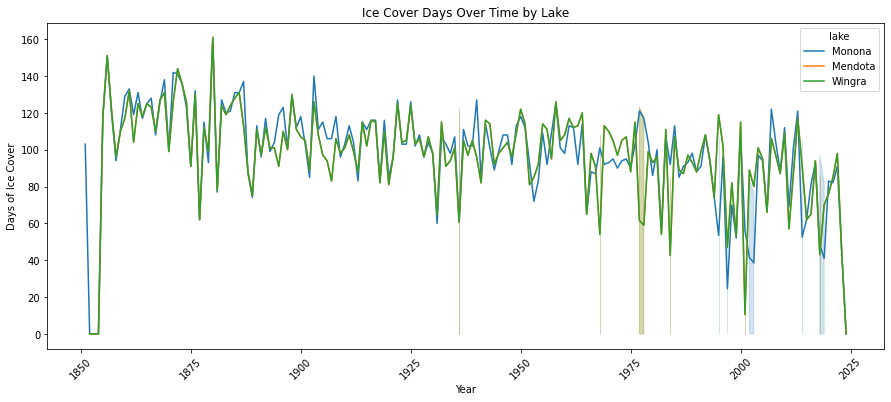

In [40]:
# Create figure for ice cover trends
plt.figure(figsize=(15, 6))
sns.lineplot(data=combined_df, x='year', y='Days of Ice Cover', hue='lake')
plt.title('Ice Cover Days Over Time by Lake')
plt.xlabel('Year')
plt.ylabel('Days of Ice Cover')
plt.xticks(rotation=45)
plt.show()

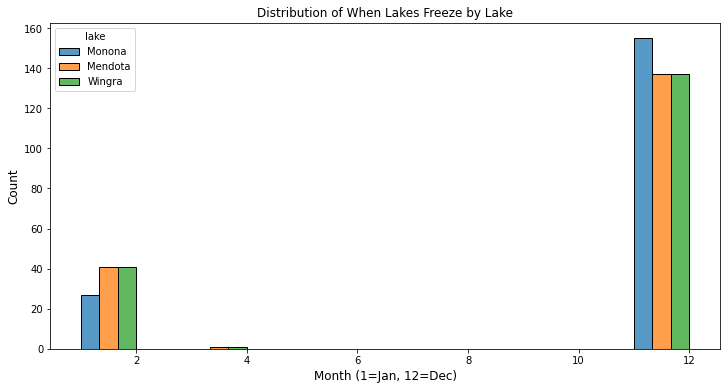

In [41]:

# Distribution of freeze months by lake
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='freeze_month',hue='lake',multiple="dodge")
plt.title('Distribution of When Lakes Freeze by Lake')
plt.xlabel('Month (1=Jan, 12=Dec)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

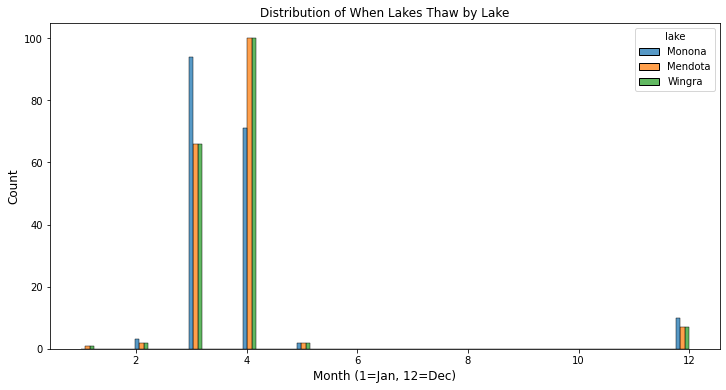

In [42]:
# Distribution of thaw months by lake
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='thaw_month',hue='lake',multiple="dodge")
plt.title('Distribution of When Lakes Thaw by Lake')
plt.xlabel('Month (1=Jan, 12=Dec)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

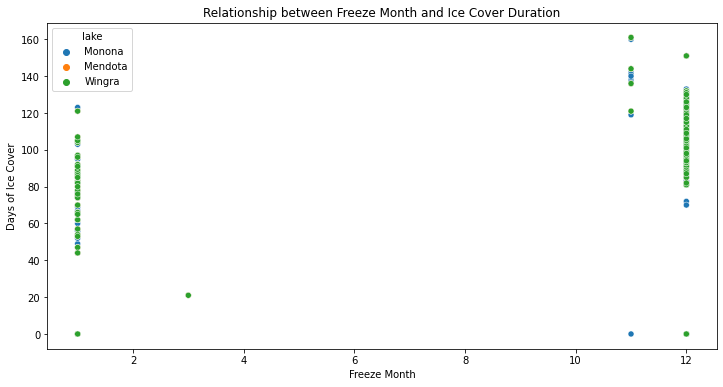

In [43]:

# Correlation between freeze timing and ice cover duration
plt.figure(figsize=(12, 6))
sns.scatterplot(data=combined_df, x='freeze_month', y='Days of Ice Cover', hue='lake')
plt.title('Relationship between Freeze Month and Ice Cover Duration')
plt.xlabel('Freeze Month')
plt.ylabel('Days of Ice Cover')
plt.show()


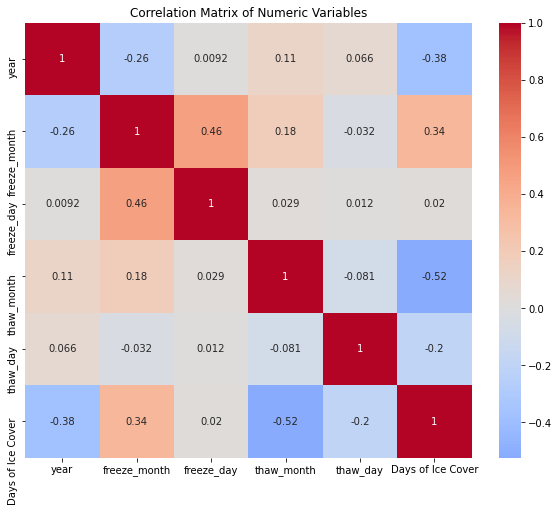

In [44]:
numeric_cols = ['year', 'freeze_month', 'freeze_day', 'thaw_month', 'thaw_day', 'Days of Ice Cover']
plt.figure(figsize=(10, 8))
sns.heatmap(combined_df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

In [45]:
combined_df.head()

,lake,year,freeze_month,freeze_day,thaw_month,thaw_day,Days of Ice Cover
0,Monona,1851,12.0,13.0,3.0,25.0,103.0
1,Monona,1852,NaN,NaN,NaN,NaN,0.0
2,Monona,1853,12.0,21.0,NaN,NaN,0.0
3,Monona,1854,NaN,NaN,NaN,NaN,0.0
4,Monona,1855,12.0,18.0,4.0,14.0,118.0


In [46]:

combined_df['decade'] = (combined_df['year'] // 10) * 10
combined_df['no_freeze'] = (combined_df['Days of Ice Cover'] == 0).astype(int)
combined_df['prev_year_ice_cover'] = combined_df.groupby('lake')['Days of Ice Cover'].shift(1)
combined_df.head()

,lake,year,freeze_month,freeze_day,thaw_month,thaw_day,Days of Ice Cover,decade,no_freeze,prev_year_ice_cover
0,Monona,1851,12.0,13.0,3.0,25.0,103.0,1850,0,NaN
1,Monona,1852,NaN,NaN,NaN,NaN,0.0,1850,1,103.0
2,Monona,1853,12.0,21.0,NaN,NaN,0.0,1850,1,0.0
3,Monona,1854,NaN,NaN,NaN,NaN,0.0,1850,1,0.0
4,Monona,1855,12.0,18.0,4.0,14.0,118.0,1850,0,0.0


In [47]:
cols_to_zero = ['freeze_month', 'freeze_day', 'thaw_month', 'thaw_day']
combined_df[cols_to_zero]=combined_df[cols_to_zero].fillna(0)
combined_df['prev_year_ice_cover'] = combined_df['prev_year_ice_cover'].fillna(combined_df['prev_year_ice_cover'].mean())

In [48]:
combined_df.isnull().sum()

lake                   0
year                   0
freeze_month           0
freeze_day             0
thaw_month             0
thaw_day               0
Days of Ice Cover      0
decade                 0
no_freeze              0
prev_year_ice_cover    0
dtype: int64

In [49]:
combined_df= pd.get_dummies(combined_df, columns=['lake'], prefix='lake')

In [50]:
split_year = int(combined_df['year'].quantile(0.8))

train_df = combined_df[combined_df['year'] < split_year]
test_df = combined_df[combined_df['year'] >= split_year]

y_train = train_df['Days of Ice Cover']
y_test = test_df['Days of Ice Cover']
X_train = train_df.drop('Days of Ice Cover',axis=1)
X_test = test_df.drop('Days of Ice Cover',axis=1)

In [51]:
X_train.shape, X_test.shape

((435, 11), (111, 11))

In [52]:
pipelines = {
    'Linear Regression': Pipeline([
        ('model', LinearRegression())
    ]),
    
    'Random Forest': Pipeline([
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    
    'SVR': Pipeline([
        ('model', SVR(kernel='rbf'))
    ])
}
predictions = {}

for name, pipeline in pipelines.items():
    print(f"\nTraining {name}...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    predictions[name] = y_pred
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f'RMSE: {rmse:.2f}')
    print(f'R2: {r2:.3f}')


Training Linear Regression...
RMSE: 16.76
R2: 0.793

Training Random Forest...
RMSE: 10.56
R2: 0.918

Training SVR...
RMSE: 50.49
R2: -0.878


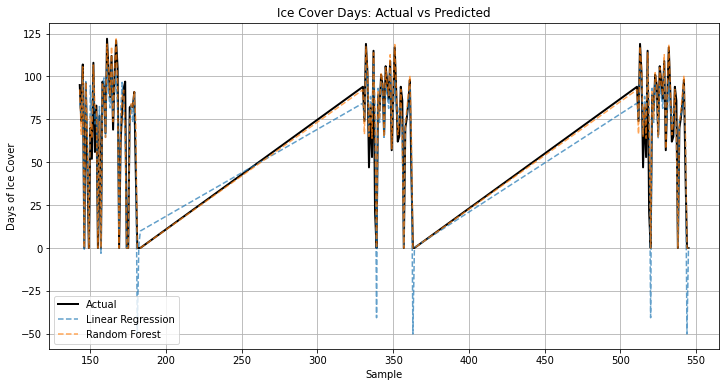

In [53]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.index, y_test, 'k-', label='Actual', linewidth=2)

# Model predictions
plt.plot(y_test.index, predictions['Linear Regression'], '--', label='Linear Regression', alpha=0.7)
plt.plot(y_test.index, predictions['Random Forest'], '--', label='Random Forest', alpha=0.7)

plt.title('Ice Cover Days: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Days of Ice Cover')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
pred_actual = pd.DataFrame({'Actual': y_test, 'Predicted': predictions['Random Forest']})
pred_actual

,Actual,Predicted
143,95.0,92.46
144,74.0,66.29
145,107.0,105.61
146,0.0,0.00
147,96.0,96.68
...,...,...
541,85.0,90.07
542,98.0,100.54
543,44.0,65.05
544,0.0,0.00
